In [1]:
# Install all needed libraries
!pip install pandas numpy matplotlib seaborn

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

sns.set(style="whitegrid")


Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Making sure the zip file exists in the same folder as this notebook
print(os.listdir())

['.ipynb_checkpoints', 'cleaned_movielens_dataset.csv', 'data', 'ml-latest-small.zip', 'movielens_analysis.ipynb']


In [3]:

# Unzip into 'data' folder
with zipfile.ZipFile("ml-latest-small.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

# Confirm extracted files
print(os.listdir("data"))


['ml-latest-small']


## Step 1 Data Preparation

In [4]:
#load each csv file
ratings = pd.read_csv("data/ml-latest-small/ratings.csv")
movies = pd.read_csv("data/ml-latest-small/movies.csv")
tags = pd.read_csv("data/ml-latest-small/tags.csv")
links = pd.read_csv("data/ml-latest-small/links.csv")

print("Files loaded successfully!")
print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)
ratings.head()




Files loaded successfully!
Ratings shape: (100836, 4)
Movies shape: (9742, 3)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Merge ratings and movies using 'movieId'
df = pd.merge(ratings, movies, on='movieId', how='left')

print("Merged dataset shape:", df.shape)
df.head()

Merged dataset shape: (100836, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [6]:
# Check for duplicates
duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)

# Check for missing values
missing = df.isnull().sum()
print("\nMissing values per column:\n", missing)


Duplicate rows: 0

Missing values per column:
 userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


In [7]:
# Convert timestamp column into datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Verify conversion
print(df['timestamp'].head())


0   2000-07-30 18:45:03
1   2000-07-30 18:20:47
2   2000-07-30 18:37:04
3   2000-07-30 19:03:35
4   2000-07-30 18:48:51
Name: timestamp, dtype: datetime64[ns]


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
 4   title      100836 non-null  object        
 5   genres     100836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 4.6+ MB


## Step 2: Feature Engineering
### Creating at least 6 new features

In [9]:
#1: Extract the 4-digit year from the movie title using regex
df['release_year'] = df['title'].str.extract(r'\((\d{4})\)').astype(float)

# Check the first few values
df[['title', 'release_year']].head()


,title,release_year
0,Toy Story (1995),1995.0
1,Grumpier Old Men (1995),1995.0
2,Heat (1995),1995.0
3,Seven (a.k.a. Se7en) (1995),1995.0
4,"Usual Suspects, The (1995)",1995.0


In [10]:
#2: Split genres by '|' and count how many per movie
df['num_genres'] = df['genres'].apply(lambda x: len(x.split('|')))

# Example check
df[['genres', 'num_genres']].head()


,genres,num_genres
0,Adventure|Animation|Children|Comedy|Fantasy,5
1,Comedy|Romance,2
2,Action|Crime|Thriller,3
3,Mystery|Thriller,2
4,Crime|Mystery|Thriller,3


In [11]:
#3 Compute the mean rating for each movieId
movie_avg = df.groupby('movieId')['rating'].mean().reset_index(name='avg_movie_rating')

# Merge it back into df
df = df.merge(movie_avg, on='movieId', how='left')

df[['movieId', 'rating', 'avg_movie_rating']].head()


,movieId,rating,avg_movie_rating
0,1,4.0,3.920930
1,3,4.0,3.259615
2,6,4.0,3.946078
3,47,5.0,3.975369
4,50,5.0,4.237745


In [12]:
#4 Compute the mean rating given by each userId
user_avg = df.groupby('userId')['rating'].mean().reset_index(name='avg_user_rating')

# Merge back into df
df = df.merge(user_avg, on='userId', how='left')

df[['userId', 'rating', 'avg_user_rating']].head()


,userId,rating,avg_user_rating
0,1,4.0,4.366379
1,1,4.0,4.366379
2,1,4.0,4.366379
3,1,5.0,4.366379
4,1,5.0,4.366379


In [13]:
#5 From the timestamp column, get the year
df['rating_year'] = df['timestamp'].dt.year

df[['timestamp', 'rating_year']].head()


,timestamp,rating_year
0,2000-07-30 18:45:03,2000
1,2000-07-30 18:20:47,2000
2,2000-07-30 18:37:04,2000
3,2000-07-30 19:03:35,2000
4,2000-07-30 18:48:51,2000


In [14]:
#6 Mark movies before year 2000 as 'classic'
df['is_classic'] = df['release_year'].apply(lambda x: 1 if x < 2000 else 0)

df[['title', 'release_year', 'is_classic']].head()


,title,release_year,is_classic
0,Toy Story (1995),1995.0,1
1,Grumpier Old Men (1995),1995.0,1
2,Heat (1995),1995.0,1
3,Seven (a.k.a. Se7en) (1995),1995.0,1
4,"Usual Suspects, The (1995)",1995.0,1


## New Feature	Purpose
#### 1	release_year	Know when each movie was released
#### 2	num_genres	Understand movie complexity
#### 3	avg_movie_rating	How popular each movie is
#### 4	avg_user_rating	How lenient/strict each user is
#### 5	rating_year	When ratings happened
#### 6	is_classic	Mark old vs modern films

In [15]:
df.to_csv("cleaned_movielens_dataset.csv", index=False)
print("Cleaned dataset saved successfully!")


Cleaned dataset saved successfully!


## Step 3: Exploratory Data Analysis (EDA)


In [16]:
# Check the overall shape
print("Shape of dataset:", df.shape)

# Check column data types and null counts
df.info()

# Summary statistics for numeric columns
df.describe()


Shape of dataset: (100836, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   userId            100836 non-null  int64         
 1   movieId           100836 non-null  int64         
 2   rating            100836 non-null  float64       
 3   timestamp         100836 non-null  datetime64[ns]
 4   title             100836 non-null  object        
 5   genres            100836 non-null  object        
 6   release_year      100818 non-null  float64       
 7   num_genres        100836 non-null  int64         
 8   avg_movie_rating  100836 non-null  float64       
 9   avg_user_rating   100836 non-null  float64       
 10  rating_year       100836 non-null  int32         
 11  is_classic        100836 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(4), object(2)
memory usage: 8.8+ 

,userId,movieId,rating,timestamp,release_year,num_genres,avg_movie_rating,avg_user_rating,rating_year,is_classic
count,100836.000000,100836.000000,100836.000000,100836,100818.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557,2008-03-19 17:01:27.368469248,1994.444990,2.722044,3.501557,3.501557,2007.722936,0.610546
min,1.000000,1.000000,0.500000,1996-03-29 18:36:55,1902.000000,1.000000,0.500000,1.275000,1996.000000,0.000000
25%,177.000000,1199.000000,3.000000,2002-04-18 09:57:46,1990.000000,2.000000,3.184713,3.258520,2002.000000,0.000000
50%,325.000000,2991.000000,3.500000,2007-08-02 20:31:02,1997.000000,3.000000,3.576087,3.508850,2007.000000,1.000000
75%,477.000000,8122.000000,4.000000,2015-07-04 07:15:44.500000,2003.000000,3.000000,3.916667,3.803226,2015.000000,1.000000
max,610.000000,193609.000000,5.000000,2018-09-24 14:27:30,2018.000000,10.000000,5.000000,5.000000,2018.000000,1.000000
std,182.618491,35530.987199,1.042529,NaN,14.361424,1.193275,0.564961,0.461687,6.890376,0.487629


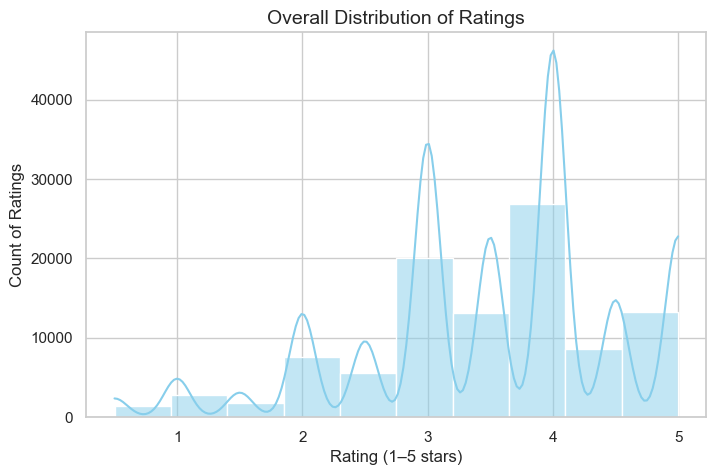

In [17]:
#Step 3.1: What do ratings look like overall?

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['rating'], bins=10, kde=True, color='skyblue')
plt.title("Overall Distribution of Ratings", fontsize=14)
plt.xlabel("Rating (1–5 stars)")
plt.ylabel("Count of Ratings")
plt.show()


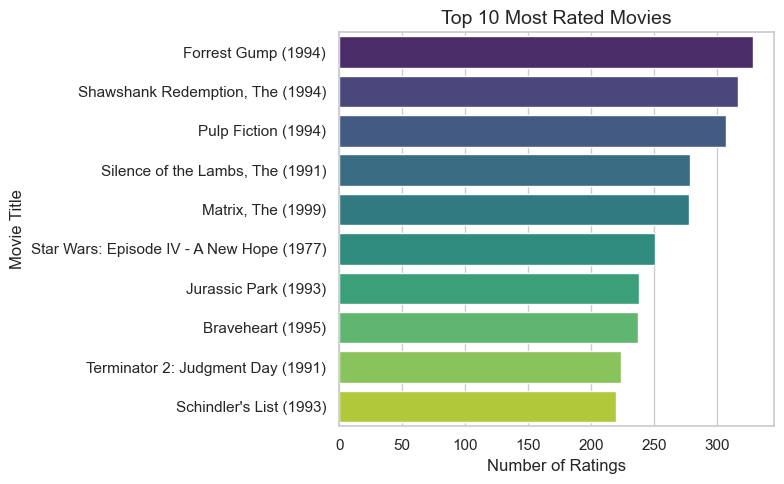

In [18]:

# Step 3.2a: How do movies differ from each other?

movie_counts = df['title'].value_counts().head(10)

plt.figure(figsize=(8,5))
sns.barplot(
    x=movie_counts.values,
    y=movie_counts.index,
    hue=movie_counts.index,   
    palette="viridis",
    legend=False
)

plt.title("Top 10 Most Rated Movies", fontsize=14)
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()




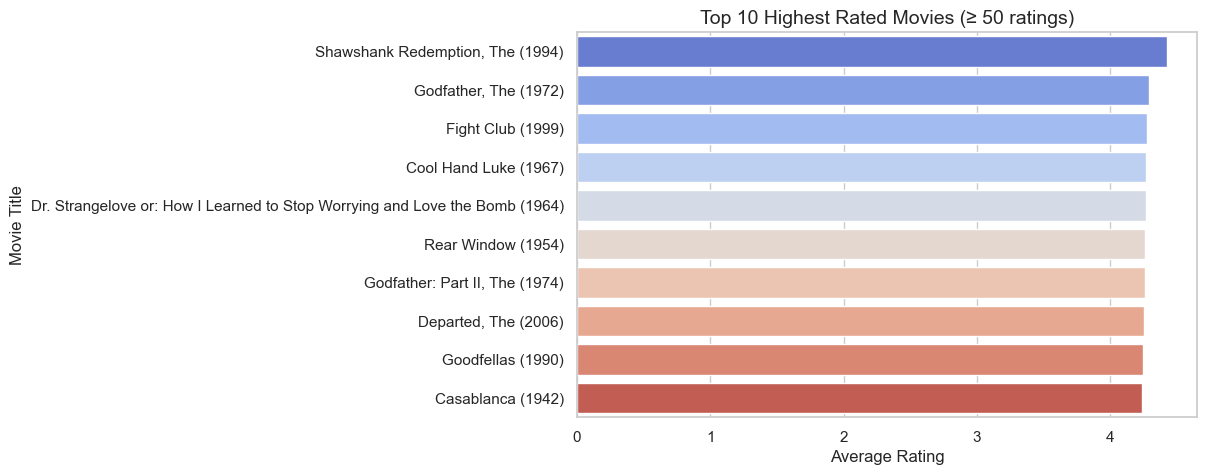

In [19]:
#Step 3.2b: how do genres differ from each other?

movie_stats = df.groupby('title').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'num_ratings']
popular_movies = movie_stats.query('num_ratings >= 50').sort_values('avg_rating', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(
    x=popular_movies['avg_rating'],
    y=popular_movies.index,
    hue=popular_movies.index,
    palette="coolwarm",
    legend=False
)
plt.title("Top 10 Highest Rated Movies (≥ 50 ratings)", fontsize=14)
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.show()



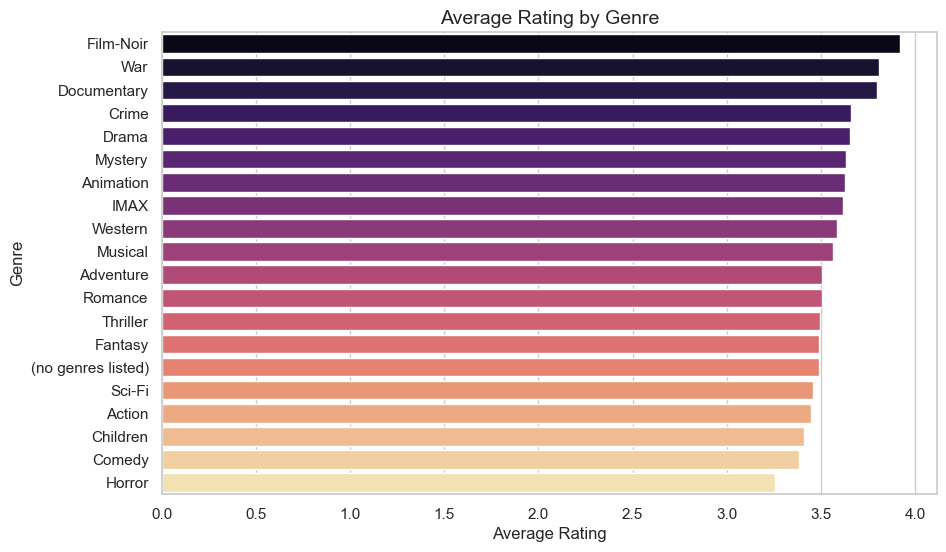

In [20]:
#Step 3.3: How do genres differ?

# Expand genres into separate rows
genres_expanded = df.assign(genre=df['genres'].str.split('|')).explode('genre')

# Average rating per genre
genre_ratings = genres_expanded.groupby('genre')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x=genre_ratings.values,
    y=genre_ratings.index,
    hue=genre_ratings.index,
    palette="magma",
    legend=False
)
plt.title("Average Rating by Genre", fontsize=14)
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()


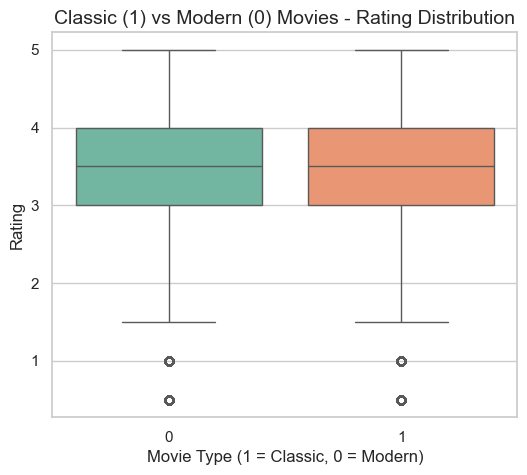

In [21]:
#Step 3.4: Classic vs Modern Movies
#Let’s compare how old movies (is_classic = 1) differ from modern ones (is_classic = 0).

plt.figure(figsize=(6,5))
sns.boxplot(
    x='is_classic',
    y='rating',
    hue='is_classic',
    data=df,
    palette='Set2',
    legend=False
    
)
plt.title("Classic (1) vs Modern (0) Movies - Rating Distribution", fontsize=14)
plt.xlabel("Movie Type (1 = Classic, 0 = Modern)")
plt.ylabel("Rating")
plt.show()


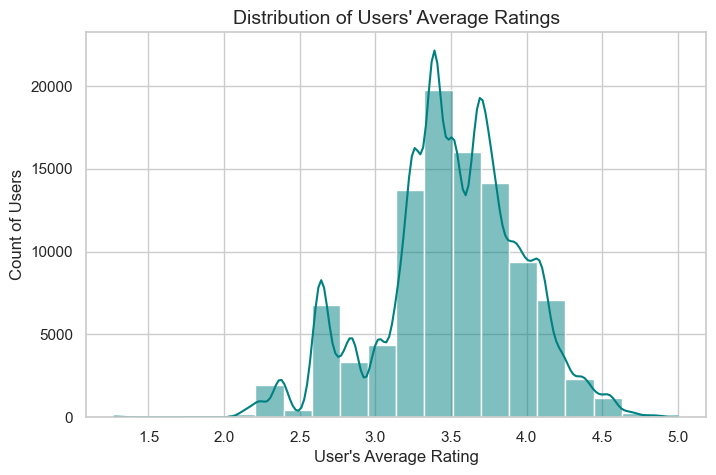

In [22]:
#Step 3.5:User Rating Behavior

plt.figure(figsize=(8,5))
sns.histplot(df['avg_user_rating'], bins=20, kde=True, color='teal')
plt.title("Distribution of Users' Average Ratings", fontsize=14)
plt.xlabel("User's Average Rating")
plt.ylabel("Count of Users")
plt.show()


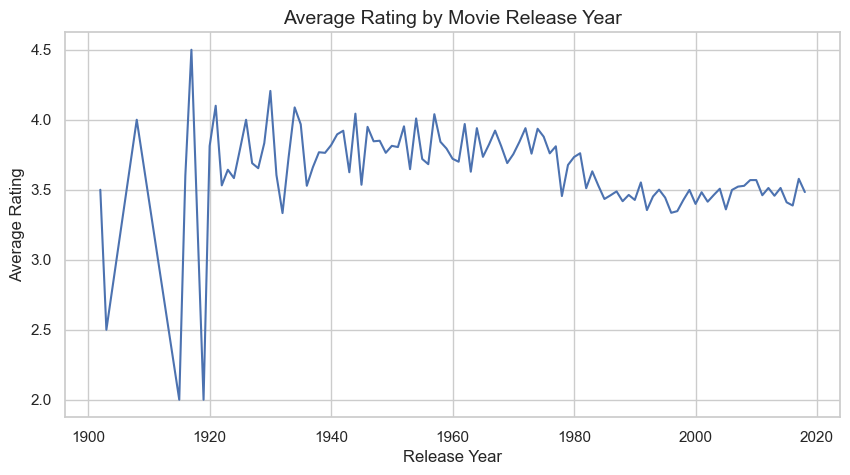

In [23]:
#Step 3.:Ratings Over Time


plt.figure(figsize=(10,5))
df.groupby('release_year')['rating'].mean().plot()
plt.title("Average Rating by Movie Release Year", fontsize=14)
plt.xlabel("Release Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()
